In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Problem Statement

In this exercise, you will implement an anomaly detection algorithm to detect anomalous behavior in server computers.

The dataset contains two features:
   * throughput (mb/s)
   * latency (ms) of response of each server

While your servers were operating, you collected $m=307$ examples of how they were behaving, and thus have an unlabeled dataset $\{x^{(1)}, \ldots, x^{(m)}\}$. 
* You suspect that the vast majority of these examples are “normal” (non-anomalous) examples of the servers operating normally, but there might also be some examples of servers acting anomalously within this dataset.

You will use a Gaussian model to detect anomalous examples in your
dataset. 
* You will first start on a 2D dataset that will allow you to visualize what the algorithm is doing.
* On that dataset you will fit a Gaussian distribution and then find values that have very low probability and hence can be considered anomalies. 

### Dataset

You will start by loading the dataset for this task. 
- The `load_data()` function shown below loads the data into the variables `X_train`, `X_val` and `y_val` 
    - You will use `X_train` to fit a Gaussian distribution 
    - You will use `X_val` and `y_val` as a cross validation set to select a threshold and determine anomalous vs normal examples

In [2]:
def load_data():
    X = np.load("X_train.npy")
    X_val = np.load("X_val.npy")
    y_val = np.load("y_val.npy")
    return X, X_val, y_val

In [3]:
X_train, X_val, y_val = load_data()

print ('The shape of X_train is:', X_train.shape)
print ('The shape of X_val is:', X_val.shape)
print ('The shape of y_val is: ', y_val.shape)

The shape of X_train is: (307, 2)
The shape of X_val is: (307, 2)
The shape of y_val is:  (307,)


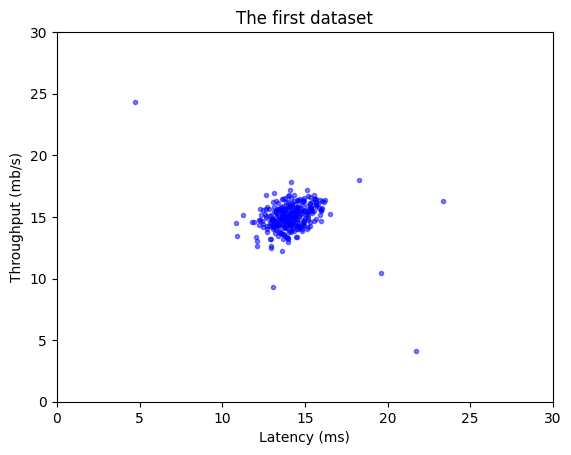

In [4]:
plt.scatter(X_train[:, 0], X_train[:, 1], marker='.', c='b', alpha=0.5)

plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')

plt.title("The first dataset")

plt.axis([0, 30, 0, 30])

plt.show()

# Probability Density Function (PDF)

### Mean & Co-Variance

In [5]:
def gaussian_parameters(X):
    """
    Calculates mean and variance of all features 
    in the dataset
    """
    
    n_samples, n_features = X.shape
    
    sum_each_feature = np.sum(X, axis=0)
    mean_each_feature = sum_each_feature / n_samples

    diff = X - mean_each_feature
    covar_matrix = (1 / n_samples) * np.dot(diff.T, diff)

    return mean_each_feature, covar_matrix

In [6]:
mu, co_var = gaussian_parameters(X_train)

print("Mean of each feature:", mu)
print("Covariance Matrix:\n", co_var)

Mean of each feature: [14.11222578 14.99771051]
Covariance Matrix:
 [[ 1.83263141 -0.22712233]
 [-0.22712233  1.70974533]]


In [7]:
np.mean(X_train.T, axis=1), np.cov(X_train.T)

(array([14.11222578, 14.99771051]),
 array([[ 1.83862041, -0.22786456],
        [-0.22786456,  1.71533273]]))

### PDF

In [8]:
from scipy.stats import multivariate_normal
mv_dist = multivariate_normal(mean=mu, cov=co_var)
p_train = mv_dist.pdf(X_train)

In [9]:
p_train.shape, p_train[:10]

((307,),
 array([0.06359522, 0.04711757, 0.07240757, 0.04686719, 0.06148477,
        0.04134712, 0.04440867, 0.03271318, 0.01527963, 0.05009353]))

In [10]:
max(p_train), min(p_train)

(0.09061227537689281, 2.2876240752225084e-21)

In [11]:
def my_multivariate_gaussian(X, mu, co_var):
    mv_dist = multivariate_normal(mu, co_var)
    p = mv_dist.pdf(X)
    return p

### Contour Plot

###### np.meshgrid: https://www.youtube.com/watch?v=sHwdoSQpMFQ&t=15s

In [12]:
X1, X2 = np.meshgrid(np.arange(0, 30, 0.5), np.arange(0, 30, 0.5))
X1.shape, X2.shape

((60, 60), (60, 60))

In [13]:
X1.ravel().shape

(3600,)

In [14]:
def plot_contours(X, mu, co_var):
    """
    This visualization shows you the probability density function of the Gaussian distribution
    """
    
    X1, X2 = np.meshgrid(np.arange(0, 30, 0.5), np.arange(0, 30, 0.5))
    P = my_multivariate_gaussian(np.stack([X1.ravel(), X2.ravel()], axis=1), mu, co_var)
    P = P.reshape(X1.shape)

    plt.plot(X[:, 0], X[:, 1], 'b.', alpha=0.5)
    
    contours = 10**(np.arange(-22., 0, 3))  # why takes that range? because of max min of p_train. OKE!!!
    plt.contour(X1, X2, P, levels=contours, linewidths=1)  # why takes that range? because max min of p
    
    plt.title("Contour Plot")
    plt.ylabel('Throughput (mb/s)')
    plt.xlabel('Latency (ms)')

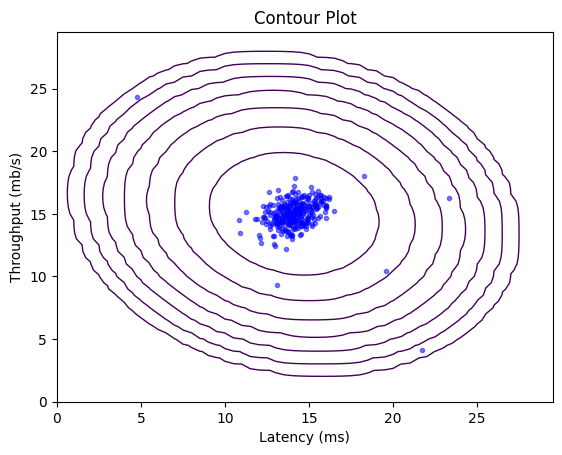

In [15]:
plot_contours(X_train, mu, co_var)

# Find Threshold based on Validation Set

Now that you have estimated the Gaussian parameters, you can investigate which examples have a very high probability given this distribution and which examples have a very low probability.  

* The low probability examples are more likely to be the anomalies in our dataset. 
* One way to determine which examples are anomalies is to select a threshold based on a cross validation set. 

In this section, you will complete the code in `select_threshold` to select the threshold $\varepsilon$ using the $F_1$ score on a cross validation set.

* For this, we will use a cross validation set
$\{(x_{\rm cv}^{(1)}, y_{\rm cv}^{(1)}),\ldots, (x_{\rm cv}^{(m_{\rm cv})}, y_{\rm cv}^{(m_{\rm cv})})\}$, where the label $y=1$ corresponds to an anomalous example, and $y=0$ corresponds to a normal example. 
* For each cross validation example, we will compute $p(x_{\rm cv}^{(i)})$. The vector of all of these probabilities $p(x_{\rm cv}^{(1)}), \ldots, p(x_{\rm cv}^{(m_{\rm cv})})$ is passed to `select_threshold` in the vector `p_val`. 
* The corresponding labels $y_{\rm cv}^{(1)}, \ldots, y_{\rm cv}^{(m_{\rm cv})}$ are passed to the same function in the vector `y_val`.

In [16]:
def select_threshold(y_val, p_val): 
    best_epsilon = 0
    best_F1 = 0

    start = min(p_val)
    end = max(p_val)
    step_size = (end - start) / 1000
    
    for epsilon in np.arange(start, end, step_size):
        anomaly_predicted = (p_val < epsilon)  # boolean array
        
        # Confusion Matrix
        TP = np.sum((anomaly_predicted == 1) & (y_val == 1))
        FP = np.sum((anomaly_predicted == 1) & (y_val == 0))
        FN = np.sum((anomaly_predicted == 0) & (y_val == 1))
        TN = np.sum((anomaly_predicted == 0) & (y_val == 0))
        
        # Metrics
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        F1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        #
        if F1_score > best_F1:
            best_F1 = F1_score
            best_epsilon = epsilon
    
    return best_epsilon, best_F1

In [17]:
p_val = my_multivariate_gaussian(X_val, mu, co_var)  # mu, co_var of X_train, OKE!!!

epsilon, f1_score = select_threshold(y_val, p_val)
epsilon, f1_score

(9.065769728392737e-05, 0.8750000000000001)

In [18]:
p_train[p_train < epsilon]

array([3.31240933e-06, 2.28762408e-21, 2.75022682e-07, 1.24832251e-12,
       2.19081104e-05, 8.12920163e-21])

---

In [19]:
outliers = (p_train < epsilon)  # boolean array

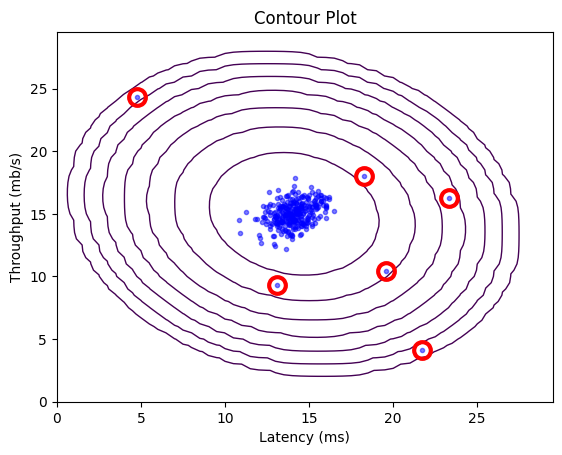

In [20]:
plot_contours(X_train, mu, co_var)

# Draw a red circle around those outliers
plt.plot(X_train[outliers, 0], X_train[outliers, 1], 'ro',
         markersize=12, markerfacecolor='none', markeredgewidth=3)